<a href="https://colab.research.google.com/github/Fragoa/Image-Coloring-with-AE-and-VAE/blob/main/ImageColoring_AE_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from skimage.metrics import structural_similarity as ssim
from torchvision.utils import make_grid

In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-06-01 19:29:24--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-06-01 19:29:24--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  90.4MB/s    in 2.6s    

2025-06-01 19:29:27 (90.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
class GrayRGBDataset(Dataset):
    def __init__(self, root_dir, transform_input=None, transform_target=None):
        self.image_paths = []
        self.transform_input = transform_input
        self.transform_target = transform_target

        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir, "images")
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        rgb_img = Image.open(img_path).convert("RGB")

        gray_img = self.transform_input(rgb_img)
        rgb_img = self.transform_target(rgb_img)

        return gray_img, rgb_img

transform_input = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

transform_target = transforms.Compose([
    transforms.ToTensor()
])

full_dataset = GrayRGBDataset("tiny-imagenet-200/train", transform_input, transform_target)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=1)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, latent_dim)
        )
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder_fc(z).view(-1, 128, 8, 8)
        x_hat = self.decoder_conv(x_hat)
        return x_hat

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder_fc(z).view(-1, 128, 8, 8)
        x_hat = self.decoder_conv(x_hat)
        return x_hat, mu, logvar

In [10]:
def loss_fn_ae(x_hat, x):
    return F.mse_loss(x_hat, x)

In [11]:
def loss_fn_vae(x_hat, x, mu, logvar, beta=0.1):
    recon_loss = F.mse_loss(x_hat, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_loss

In [12]:
def psnr(x_hat, x):
    mse = F.mse_loss(x_hat, x).item()
    return 10 * np.log10(1.0 / mse)

In [14]:
def mae(x_hat, x):
    return torch.abs(x_hat - x).mean().item()

In [13]:
def ssim_metric(x_hat, x):
    x_hat_np = x_hat.squeeze().permute(1, 2, 0).cpu().numpy()
    x_np = x.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(x_np, x_hat_np, channel_axis=-1, data_range=1.0)

In [8]:
def train_model(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for gray, rgb in loader:
        gray, rgb = gray.cuda(), rgb.cuda()
        optimizer.zero_grad()
        if isinstance(model, VAE):
            x_hat, mu, logvar = model(gray)
            loss = criterion(x_hat, rgb, mu, logvar)
        else:
            x_hat = model(gray)
            loss = criterion(x_hat, rgb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [15]:
def evaluate_model(model, loader):
    model.eval()
    psnr_list, ssim_list, mae_list = [], [], []
    with torch.no_grad():
        for gray, rgb in loader:
            gray, rgb = gray.cuda(), rgb.cuda()
            if isinstance(model, VAE):
                x_hat, _, _ = model(gray)
            else:
                x_hat = model(gray)
            psnr_list.append(psnr(x_hat, rgb))
            ssim_list.append(ssim_metric(x_hat, rgb))
            mae_list.append(mae(x_hat, rgb))
    return np.mean(psnr_list), np.mean(ssim_list), np.mean(mae_list)

In [9]:
def visualize(model, loader, num=5):
    model.eval()
    fig, axs = plt.subplots(num, 3, figsize=(9, 3 * num))
    with torch.no_grad():
        for i, (gray, rgb) in enumerate(loader):
            gray, rgb = gray.cuda(), rgb.cuda()
            if isinstance(model, VAE):
                x_hat, _, _ = model(gray)
            else:
                x_hat = model(gray)
            axs[i, 0].imshow(gray[0][0].cpu(), cmap='gray')
            axs[i, 1].imshow(x_hat[0].permute(1, 2, 0).cpu())
            axs[i, 2].imshow(rgb[0].permute(1, 2, 0).cpu())
            axs[i, 0].set_title("Input")
            axs[i, 1].set_title("Predicted")
            axs[i, 2].set_title("Ground Truth")
            for j in range(3): axs[i, j].axis('off')
            if i == num - 1:
                break
    plt.tight_layout()
    plt.show()

Training Autoencoder...
[AE] Epoch 1, Train Loss: 0.0295
[AE] Epoch 2, Train Loss: 0.0224
[AE] Epoch 3, Train Loss: 0.0214
[AE] Epoch 4, Train Loss: 0.0210
[AE] Epoch 5, Train Loss: 0.0207
[AE] Epoch 6, Train Loss: 0.0205
[AE] Epoch 7, Train Loss: 0.0204
[AE] Epoch 8, Train Loss: 0.0202
[AE] Epoch 9, Train Loss: 0.0199
[AE] Epoch 10, Train Loss: 0.0196
[AE] PSNR: 17.36509558224629 SSIM: 0.45030376 MAE: 0.10626888481415808


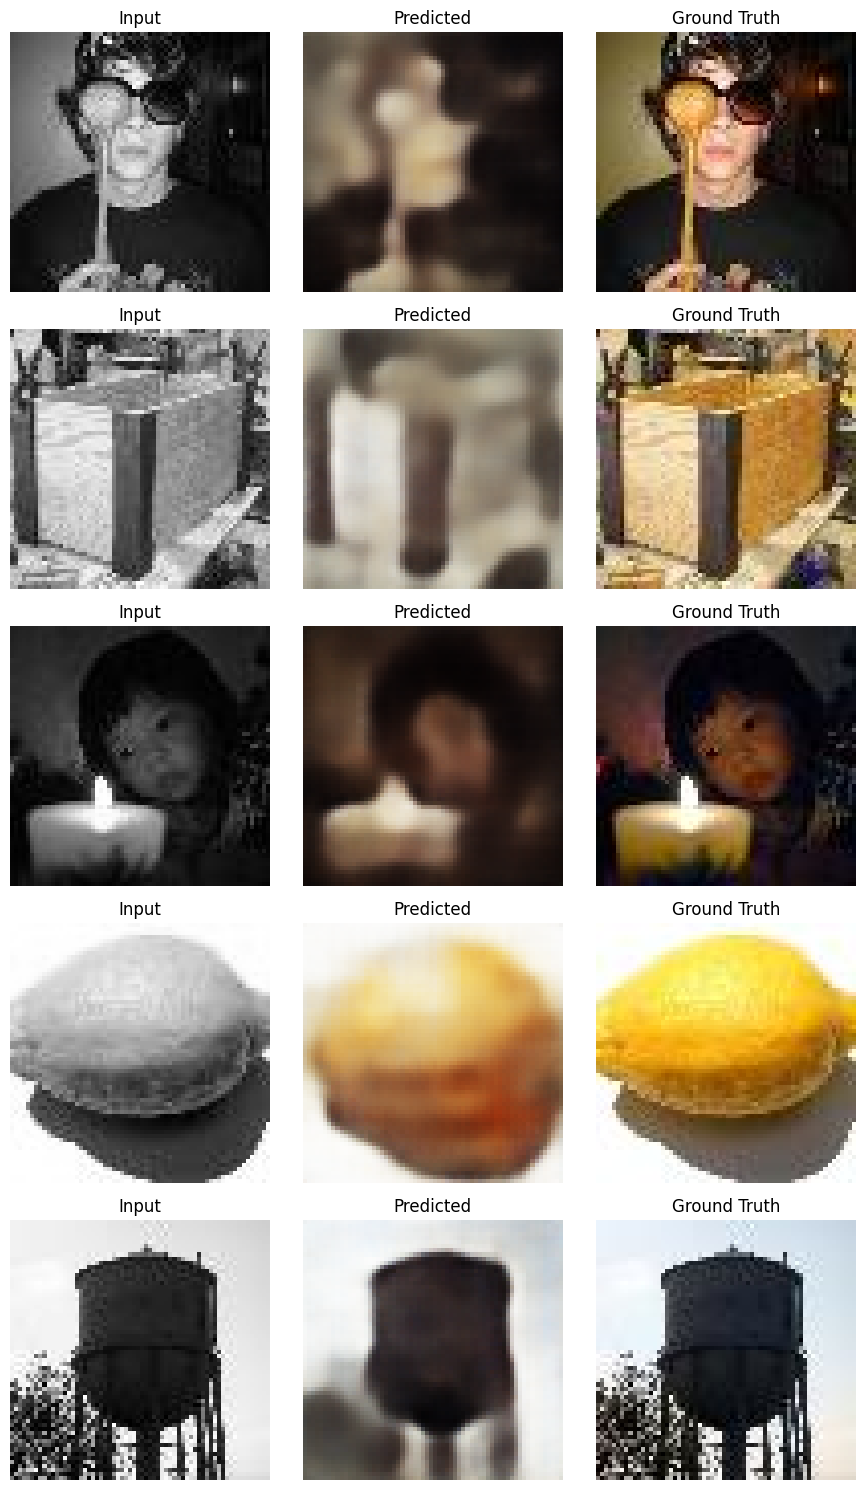

In [16]:
# Run Autoencoder
print("Training Autoencoder...")
ae_model = Autoencoder().cuda()
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3)
for epoch in range(10):
    train_loss = train_model(ae_model, train_loader, ae_optimizer, loss_fn_ae)
    print(f"[AE] Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

psnr_ae, ssim_ae, mae_ae = evaluate_model(ae_model, test_loader)
print("[AE] PSNR:", psnr_ae, "SSIM:", ssim_ae, "MAE:", mae_ae)
visualize(ae_model, test_loader, num=5)


Training Variational Autoencoder...
[VAE] Epoch 1, Train Loss: 0.0758
[VAE] Epoch 2, Train Loss: 0.0755
[VAE] Epoch 3, Train Loss: 0.0754
[VAE] Epoch 4, Train Loss: 0.0754
[VAE] Epoch 5, Train Loss: 0.0754
[VAE] Epoch 6, Train Loss: 0.0754
[VAE] Epoch 7, Train Loss: 0.0754
[VAE] Epoch 8, Train Loss: 0.0754
[VAE] Epoch 9, Train Loss: 0.0754
[VAE] Epoch 10, Train Loss: 0.0754
[VAE] PSNR: 11.66453465913543 SSIM: 0.14197995 MAE: 0.23250942788074414


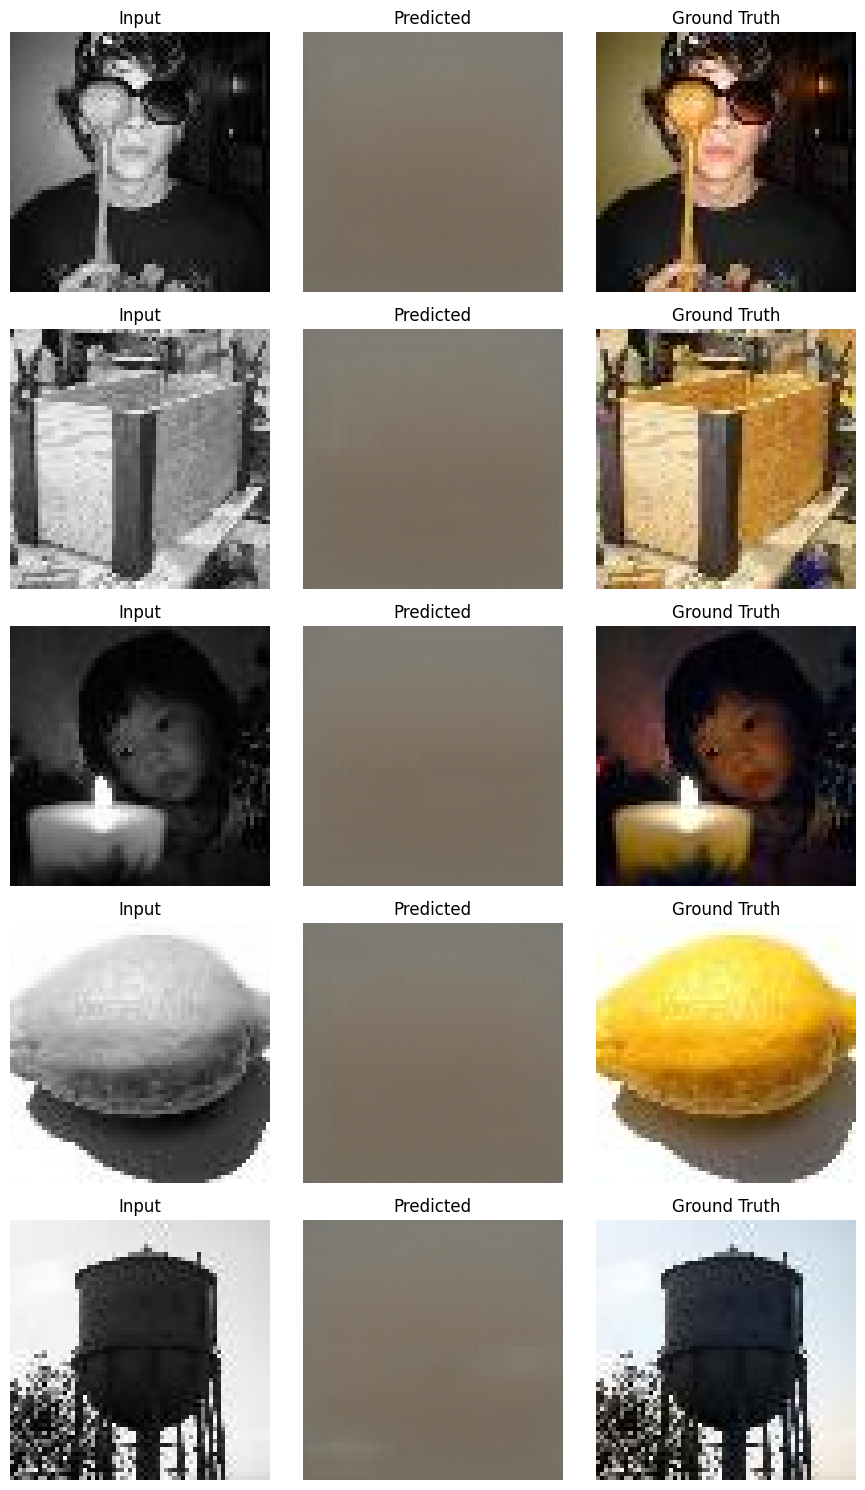

In [17]:
# Run Variational Autoencoder
print("\nTraining Variational Autoencoder...")
vae_model = VAE().cuda()
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(10):
    train_loss = train_model(vae_model, train_loader, vae_optimizer, loss_fn_vae)
    print(f"[VAE] Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

psnr_vae, ssim_vae, mae_vae = evaluate_model(vae_model, test_loader)
print("[VAE] PSNR:", psnr_vae, "SSIM:", ssim_vae, "MAE:", mae_vae)
visualize(vae_model, test_loader, num=5)



Visualizing VAE latent space with PCA...


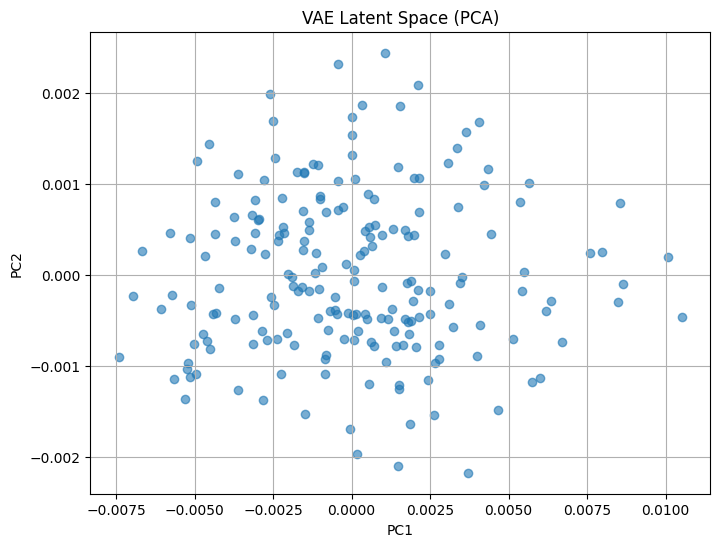

In [20]:
print("\nVisualizing VAE latent space with PCA...")
from sklearn.decomposition import PCA

def visualize_latent_space(model, loader, num_samples=200):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            _, mu, _ = model(x)
            latents.append(mu.cpu().numpy())
            if len(latents)*x.size(0) > num_samples:
                break
    latents = np.concatenate(latents, axis=0)[:num_samples]
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latents)
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.6)
    plt.title("VAE Latent Space (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

visualize_latent_space(vae_model, test_loader)
